In [114]:
from asist.utility import binavg, running_mean, power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.wavewire import read_ww_from_toa5
from sustain_drag_2020.fetch import fetch
import warnings
import os
import pandas as pd
warnings.filterwarnings('ignore')


In [127]:
DATAPATH_WO = '/Users/peisen/Downloads/sustain-drag-2020/20191121'

DATAPATH_JW1 = '/Users/peisen/Downloads/sustain-drag-2020/20200109'
DATAPATH_JW2 = '/Users/peisen/Downloads/sustain-drag-2020/20200110'
files_JW2 = glob.glob(DATAPATH_JW2 + '/TOA5_OSSwave*.dat')
files_JW1 = glob.glob(DATAPATH_JW1 + '/TOA5_OSSwave*.dat')
files_WO = glob.glob(DATAPATH_WO + '/TOA5_OSSwave*.dat')

# experiment parameters
fan = range(0, 65, 5)
run_seconds = 600
start_time_WO = datetime(2019, 11,21,16, 10)
start_time_JW1 = datetime(2020,1,9, 19, 36)
start_time_JW2 = datetime(2020, 1,10, 2, 40)

end_time_WO = start_time_WO + timedelta(seconds=run_seconds * len(fan))
end_time_JW1 = start_time_JW1 + timedelta(seconds=run_seconds * len(fan))
end_time_JW2 = start_time_JW2+ timedelta(seconds=run_seconds * len(fan))

In [128]:
time_JW2, w1_JW2, w2_JW2, w3_JW2= read_ww_from_toa5(files_JW2)
time_JW1, w1_JW1, w2_JW1, w3_JW1= read_ww_from_toa5(files_JW1)
time_WO, w1_WO, w2_WO, w3_WO= read_ww_from_toa5(files_WO)


Reading  TOA5_OSSwavex4.elev_3007_2020_01_10_0200.dat
Reading  TOA5_OSSwavex4.elev_3008_2020_01_10_0300.dat
Reading  TOA5_OSSwavex4.elev_3009_2020_01_10_0400.dat
Reading  TOA5_OSSwavex4.elev_2999_2020_01_09_1900.dat
Reading  TOA5_OSSwavex4.elev_3001_2020_01_09_2100.dat
Reading  TOA5_OSSwavex4.elev_3000_2020_01_09_2000.dat
Reading  TOA5_OSSwavex4.elev_1804_2019_11_21_1600.dat
Reading  TOA5_OSSwavex4.elev_1805_2019_11_21_1700.dat
Reading  TOA5_OSSwavex4.elev_1806_2019_11_21_1800.dat


In [129]:
def elevation_from_ww(x, max_value=0.3, max_jump=0.10, interpolation_method='polynomial'):
    xx = x[:]-np.mean(x[:20 * 600])   # offset first 10 minutes
    xdiff = xx[1:] - xx[:-1]
    xx[1:][np.abs(xdiff) > max_jump] = np.nan # difference between 2 points should not exceed max_jump
    xx[np.abs(xx) > max_value] = np.nan # elevation should not go below min_trough
    return np.array(pd.DataFrame(data=xx).interpolate(method=interpolation_method, order=3))[:,0]

Text(0, 0.5, 'Elevation [m]')

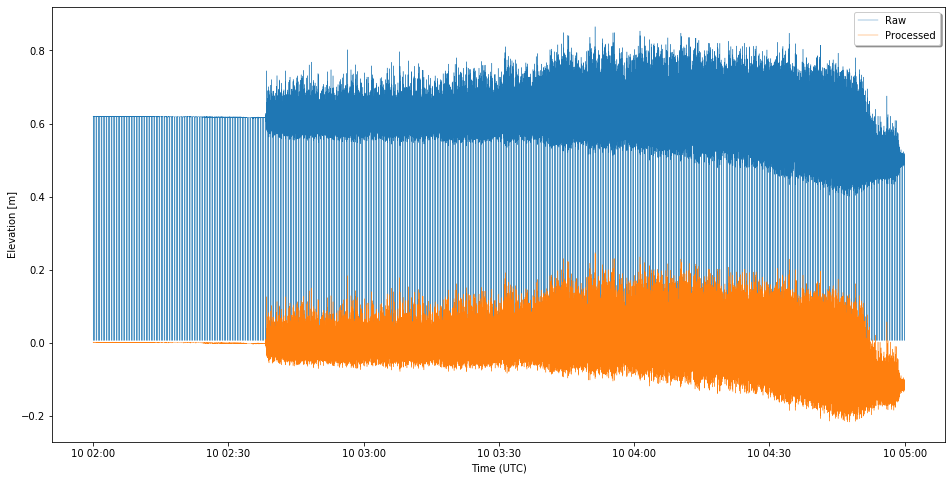

In [130]:
fig = plt.figure(figsize=(16, 8))
plt.plot(time_JW2, w1_JW2, lw=0.4, label='Raw')
plt.plot(time_JW2, elevation_from_ww(w1_JW2), lw=0.4, label='Processed')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.xlabel('Time (UTC)')
plt.ylabel('Elevation [m]')



In [131]:
# map UDM arrays to sequential positions in the tank
ww_WO = np.zeros((3, w1_WO.size))
ww_WO[0,:] = elevation_from_ww(w1_WO[:])
ww_WO[1,:] = elevation_from_ww(w2_WO[:])
ww_WO[2,:] = elevation_from_ww(w3_WO[:])

ww_JW1= np.zeros((3, w1_JW1.size))
ww_JW1[0,:] = elevation_from_ww(w1_JW1[:])
ww_JW1[1,:] = elevation_from_ww(w2_JW1[:])
ww_JW1[2,:] = elevation_from_ww(w3_JW1[:])

ww_JW2 = np.zeros((3, w1_JW2.size))
ww_JW2[0,:] = elevation_from_ww(w1_JW2[:])
ww_JW2[1,:] = elevation_from_ww(w2_JW2[:])
ww_JW2[2,:] = elevation_from_ww(w3_JW2[:])

fetch = np.array([9.705 , 9.925 , 9.925 ]) # TODO get exact values


In [132]:


# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0_WO = [start_time_WO + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1_WO = [start_time_WO + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

t0_JW1 = [start_time_JW1 + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1_JW1 = [start_time_JW1 + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

t0_JW2 = [start_time_JW2 + timedelta(seconds=n * run_seconds + 60)
    for n in range(len(fan))]
t1_JW2 = [start_time_JW2 + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


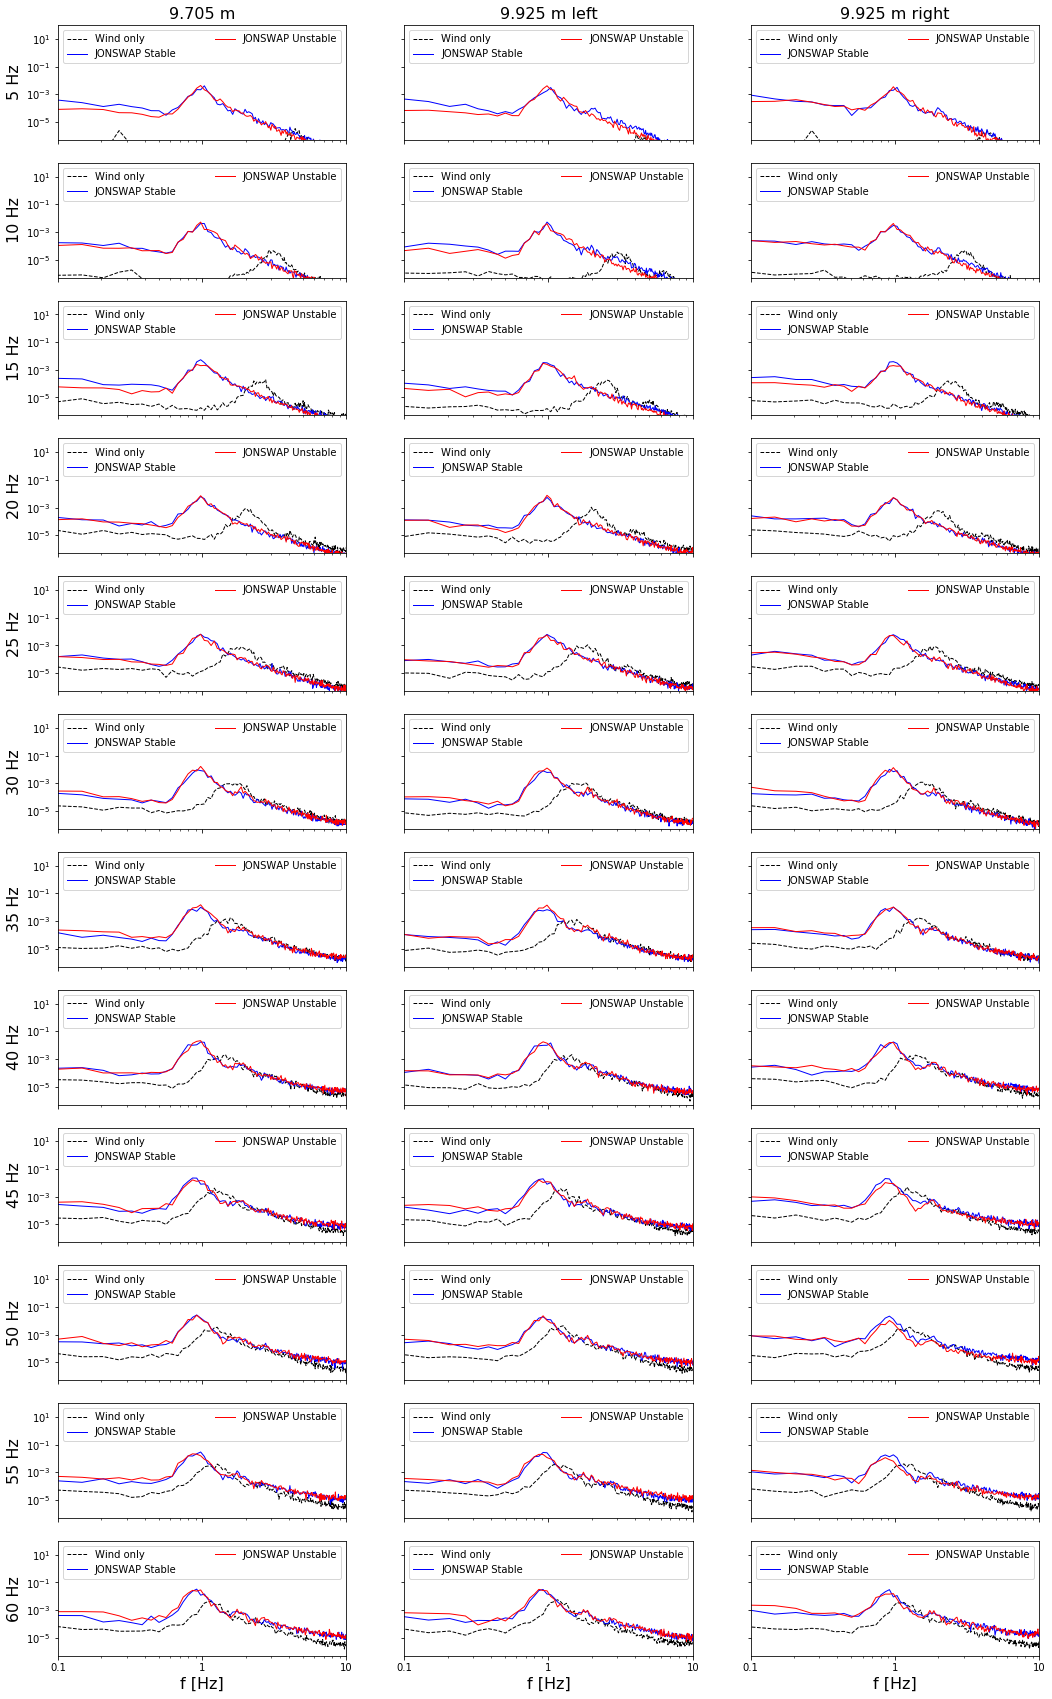

In [156]:
#Start Spectral Comparison between Wind-only and JONSWAP (stable and unstable)
fig = plt.figure(figsize=(30, 30))
for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask_WO = (time_WO >= t0_WO[n]) & (time_WO <= t1_WO[n])
    mask_JW1 = (time_JW1 >= t0_JW1[n]) & (time_JW1 <= t1_JW1[n])
    mask_JW2 = (time_JW2 >= t0_JW2[n]) & (time_JW2 <= t1_JW2[n])

  
    for i in range(3):
        ax = plt.subplot2grid((12, 5), (n - 1, i))
        e_WO = detrend(ww_WO[i,mask_WO])
        F_WO, f_WO, df_WO = power_spectrum(e_WO, 1 / 20, binsize=32)
        ax.loglog(f_WO, F_WO, 'k--',lw=1)
        
        e_JW1 = detrend(ww_JW1[i,mask_JW1])
        F_JW1, f_JW1, df_JW1 = power_spectrum(e_JW1, 1 / 20, binsize=32)
        ax.loglog(f_JW1, F_JW1, lw=1,color='b')        
        
        
        e_JW2 = detrend(ww_JW2[i,mask_JW2])
        F_JW2, f_JW2, df_JW2 = power_spectrum(e_JW2, 1 / 20, binsize=32)
        ax.loglog(f_JW2, F_JW2, lw=1,color='r') 
        
        plt.xticks((1e-1,1,1e1),('0.1','1','10'))
        plt.xlim(1e-1, 1e1)
        plt.ylim(5e-7, 100)

        plt.legend(('Wind only','JONSWAP Stable','JONSWAP Unstable'),loc=1
        ,ncol=2,mode='expand')
        if i == 1: 
            if n == 1: plt.title(str(fetch[i]) + ' m left', fontsize=16)
        if i == 2:
            if n == 1: plt.title(str(fetch[i]) + ' m right', fontsize=16)
        if i==0:
            if n == 1: plt.title(str(fetch[i]) + ' m', fontsize=16)
        if n == 12: plt.xlabel('f [Hz]', fontsize=16)
        if n != 12: ax.set_xticklabels([])
        if i == 0: plt.ylabel(str(fan[n]) + ' Hz', fontsize=16)
        if i != 0: ax.set_yticklabels([])

plt.savefig('Spectra Comparison.png')